## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Constants

In [2]:
DIR = "/mnt/perkinsdata/tongue_STOmics/benchmarking/25_2k_4"
FILE = "accuracy.csv"

MEASURES = [("tf", "Recall"), ("tf", "Precision"), ("ft", "Entropy_wo")]
ALGOS = ["Watershed", "Cellpose", "DeepCell"]

In [4]:
# make output dir
OUTPUT = os.path.join(DIR, "plots")
!mkdir $OUTPUT

## Load Data

In [5]:
data = pd.read_csv(os.path.join(DIR, FILE))

In [30]:
# get plotting data from data
means = []
stds = []
for m in MEASURES:
    means.append(list(data[data["TF_FT"] == m[0]][m[1] + "_m"]))
    stds.append(list(data[data["TF_FT"] == m[0]][m[1] + "_s"]))


In [31]:
means

[[0.675, 0.8588, 0.7477], [0.7472, 0.8815, 0.3563], [0.1478, 0.156, 0.6717]]

## Plotting

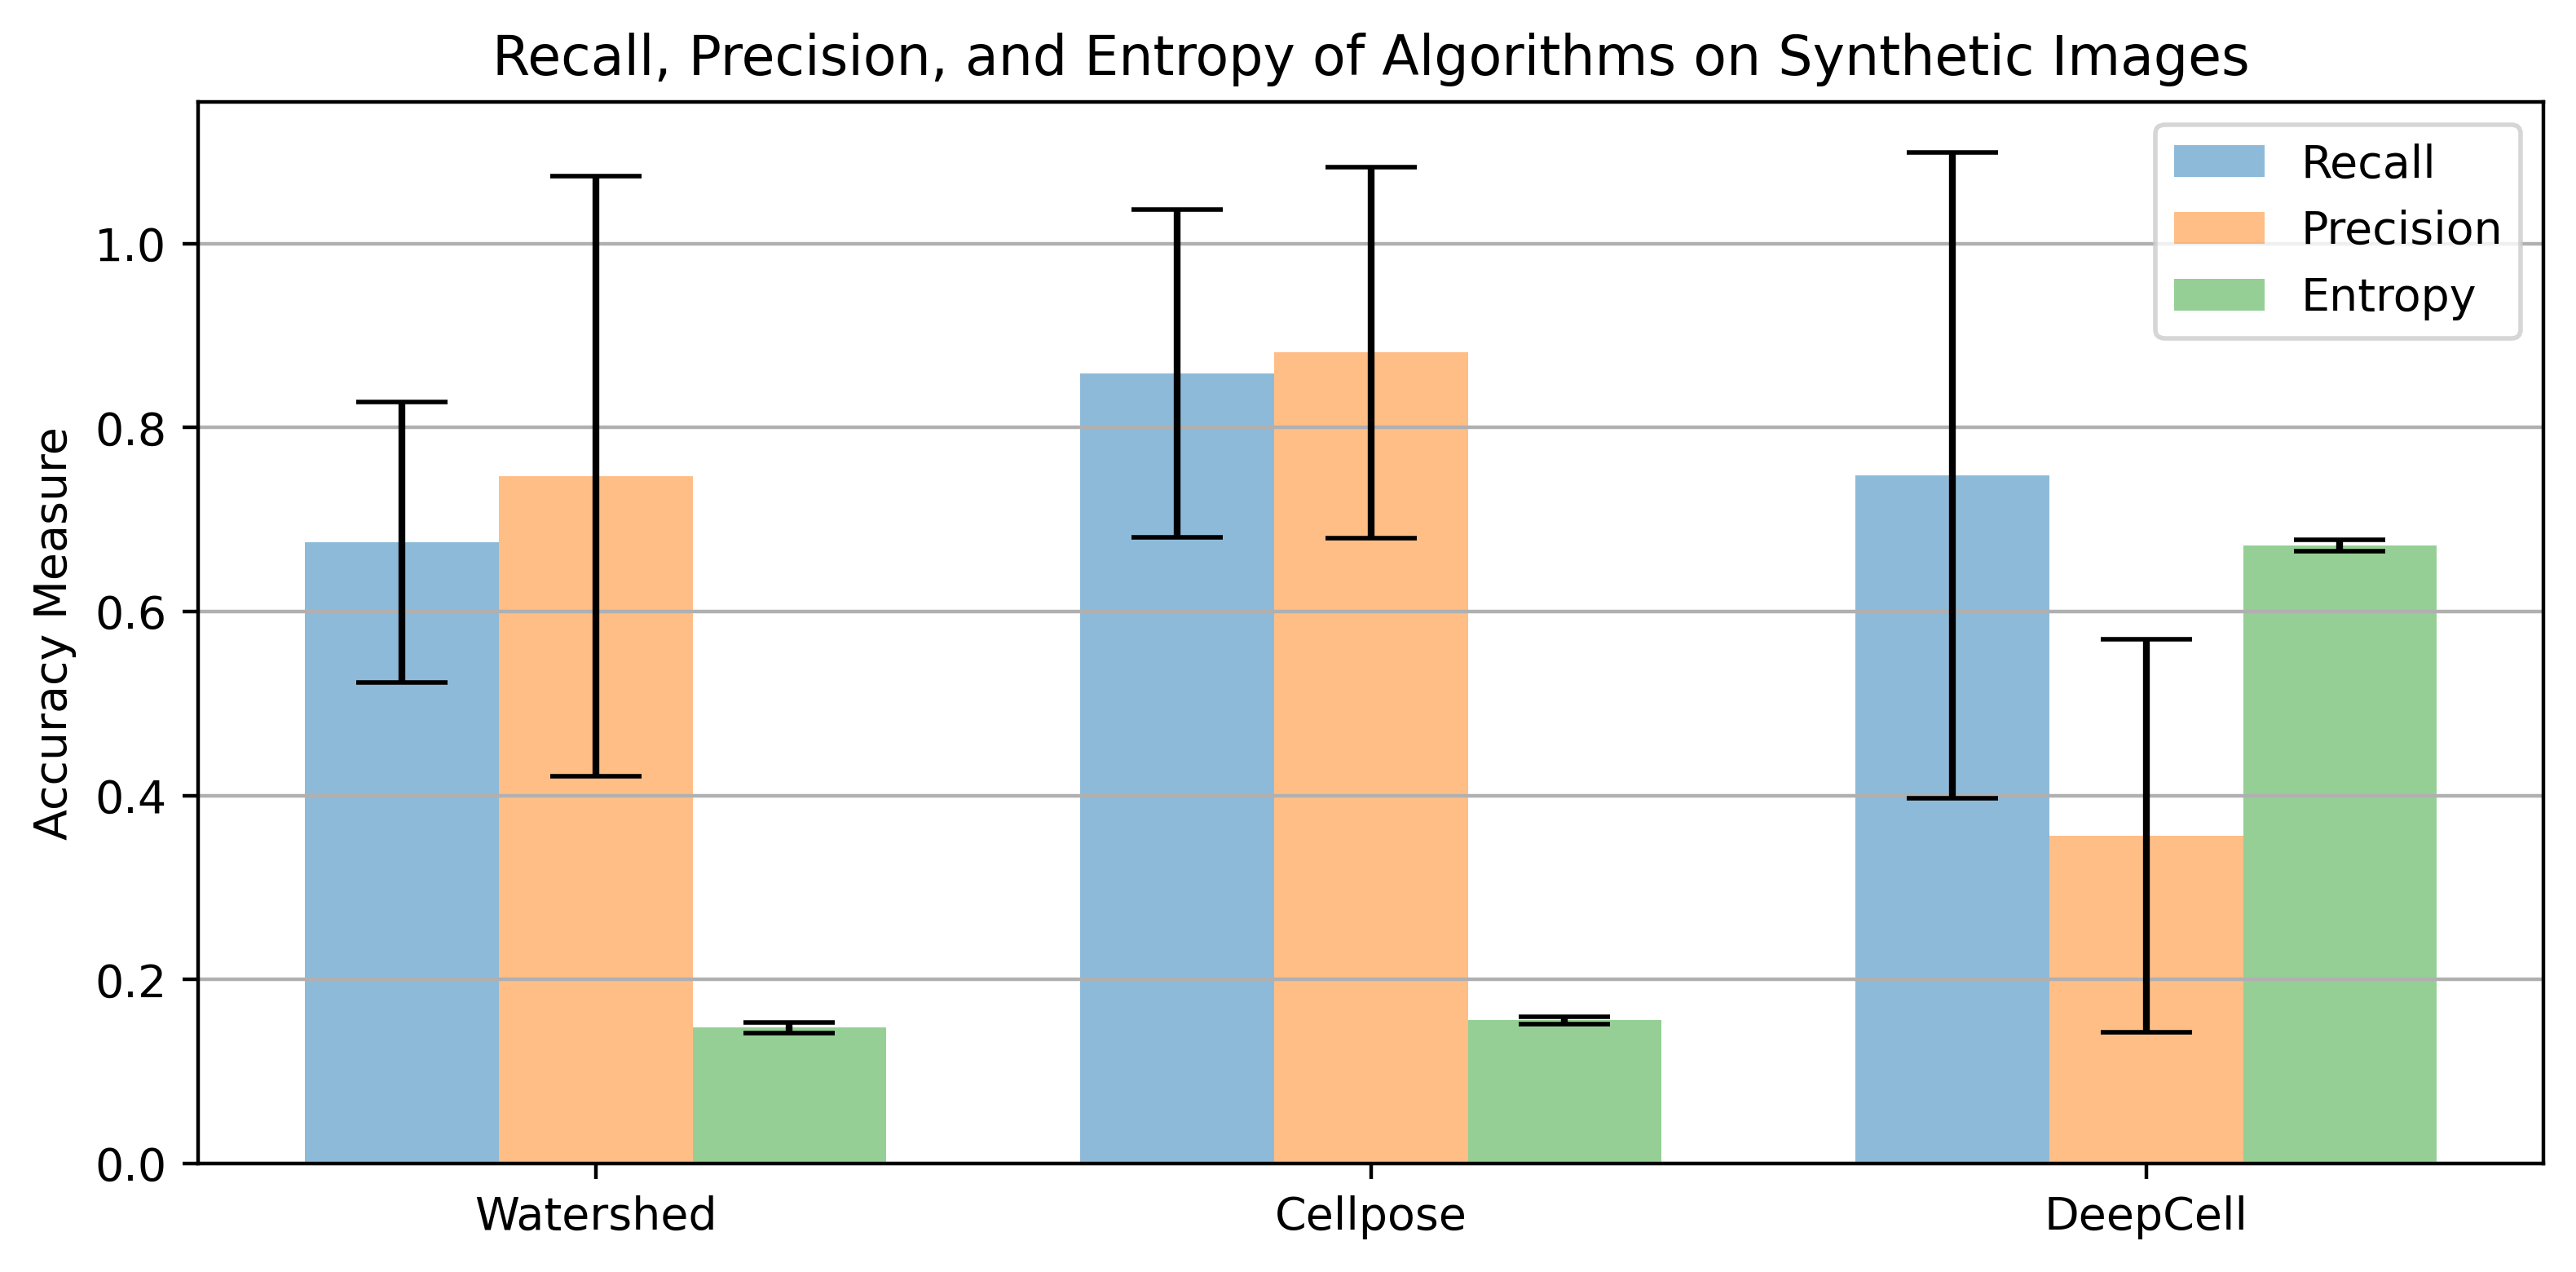

In [35]:
fig, ax = plt.subplots()

# set white background
fig.patch.set_facecolor('white')

# set im size
fig.set_size_inches(8, 4)
fig.set_dpi(400)

# add bar plots
ax.bar(X + 0.00, means[0], yerr=stds[0], align='center', alpha=0.5, ecolor='black', capsize=10, width = 0.25)
ax.bar(X + 0.25, means[1], yerr=stds[1], align='center', alpha=0.5, ecolor='black', capsize=10, width = 0.25)
ax.bar(X + 0.50, means[2], yerr=stds[2], align='center', alpha=0.5, ecolor='black', capsize=10, width = 0.25)

ax.set_ylabel('Accuracy Measure')
ax.set_xticks(X+0.25)
ax.set_xticklabels(ALGOS)
ax.set_title('Recall, Precision, and Entropy of Algorithms on Synthetic Images')
ax.yaxis.grid(True)

ax.legend(labels=['Recall', 'Precision', "Entropy"])

# Save the figure and show
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT, "x_method.png"))
plt.show()

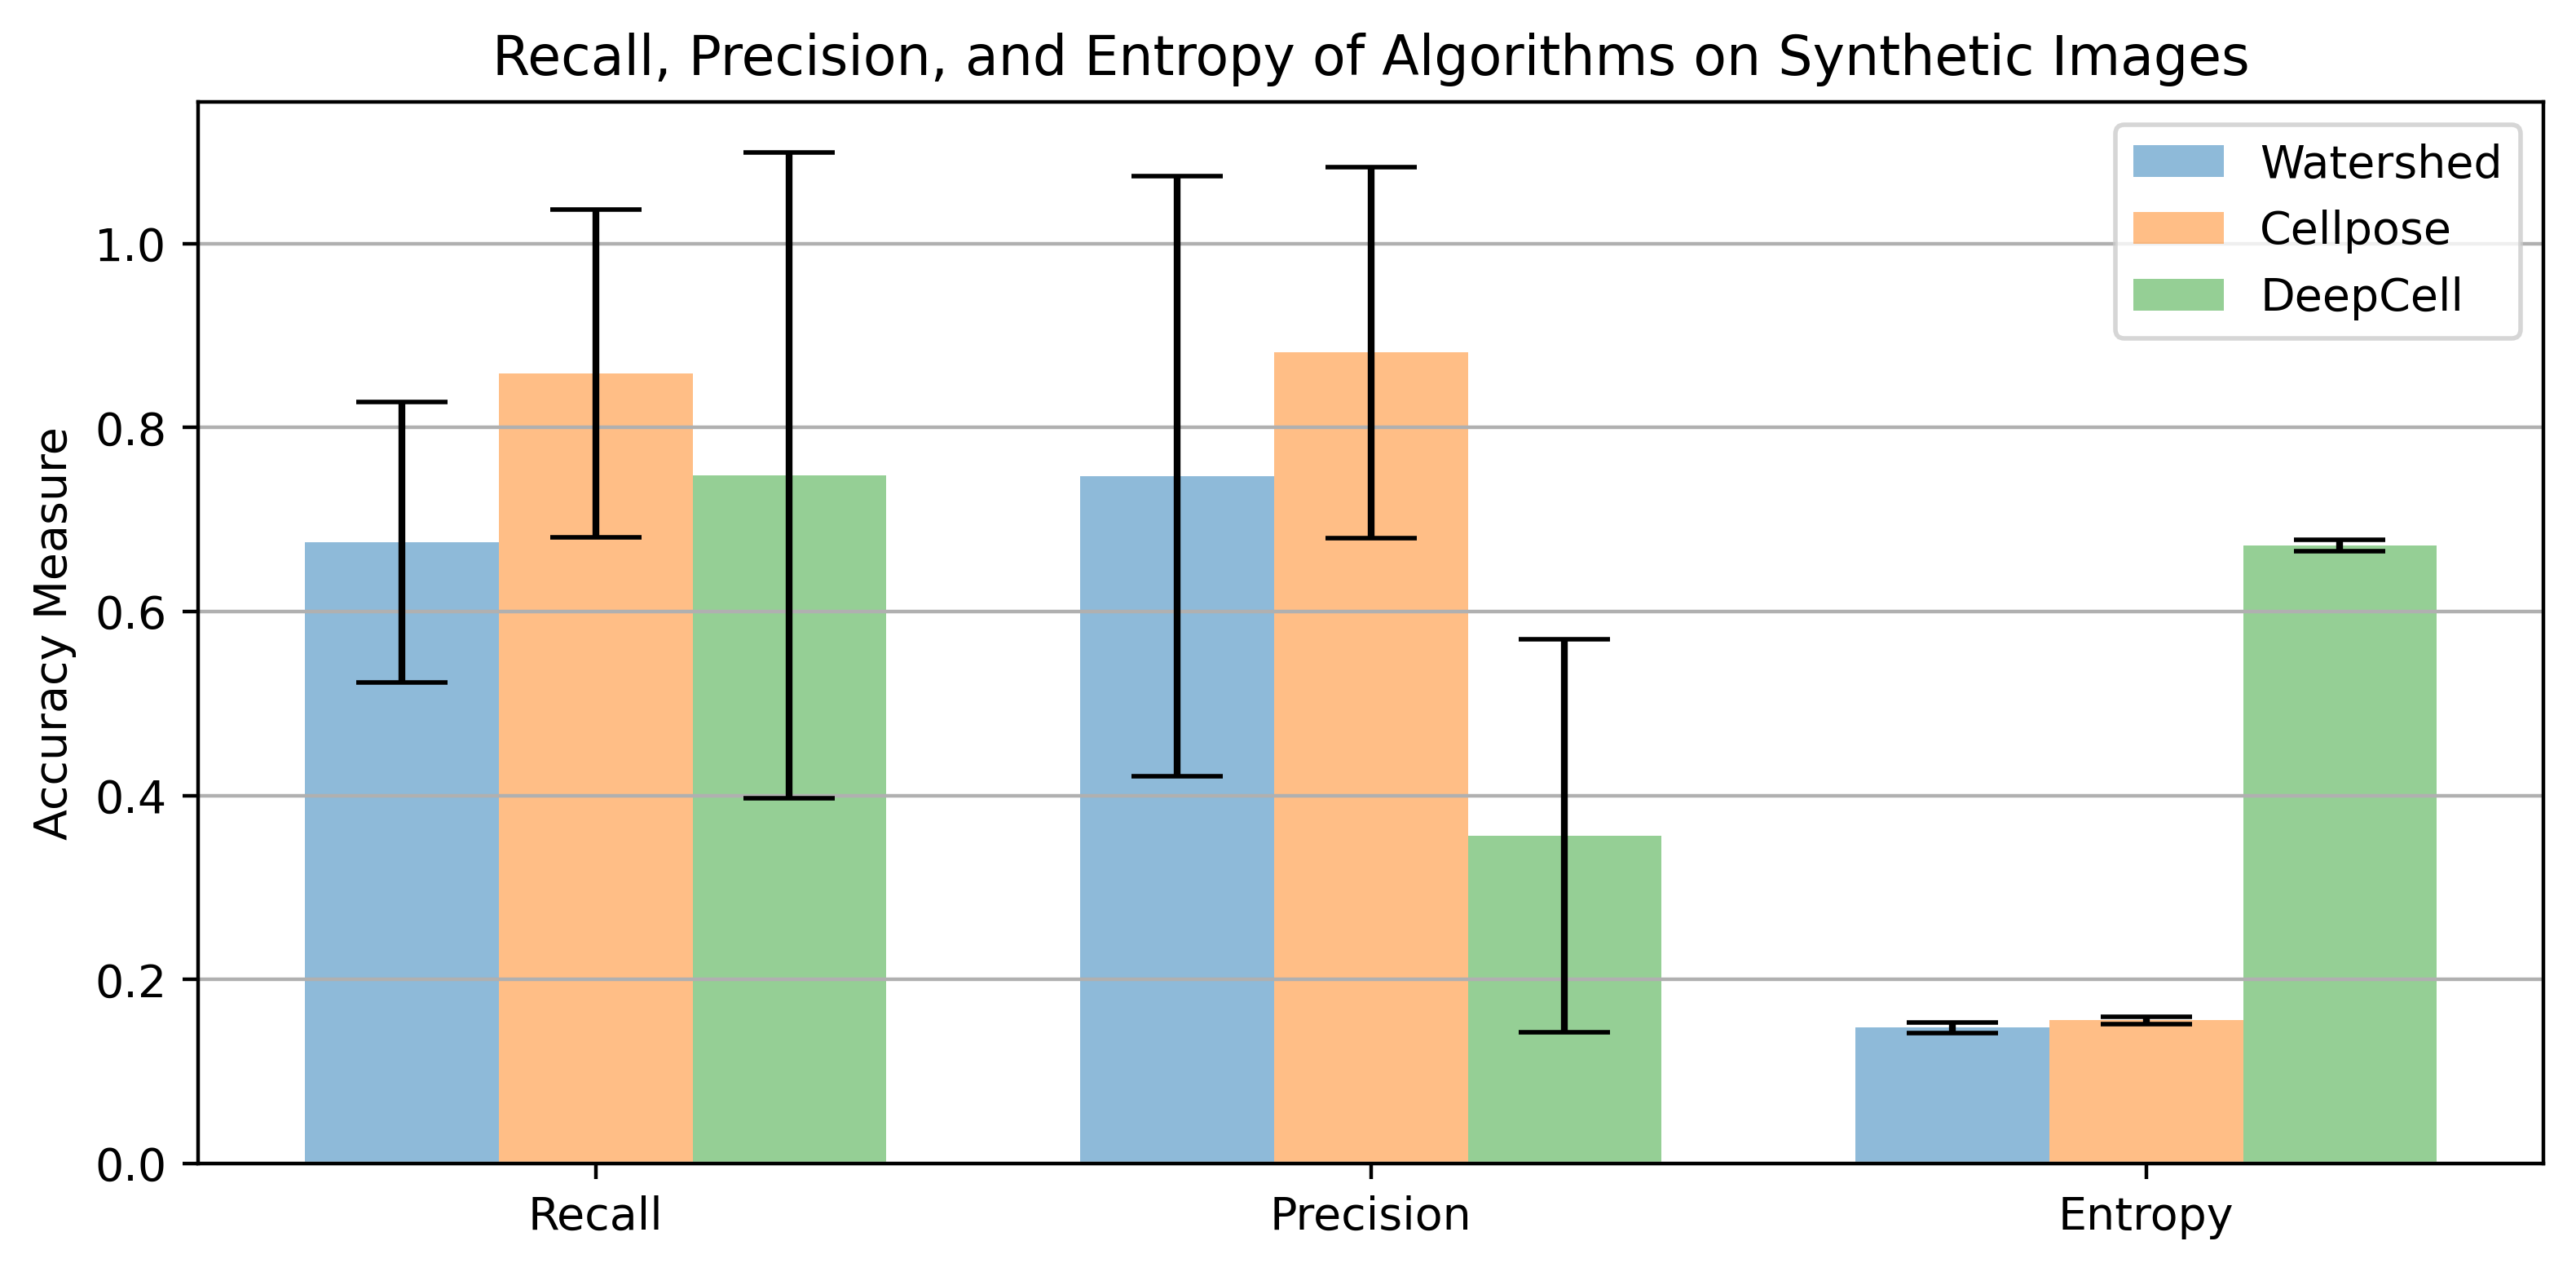

In [41]:
fig, ax = plt.subplots()

# set white background
fig.patch.set_facecolor('white')

# set im size
fig.set_size_inches(8, 4)
fig.set_dpi(400)

# tranpose means and stds
means_t = np.array(means).T
stds_t = np.array(stds).T

# add bar plots
ax.bar(X + 0.00, means_t[0], yerr=stds_t[0], align='center', alpha=0.5, ecolor='black', capsize=10, width = 0.25)
ax.bar(X + 0.25, means_t[1], yerr=stds_t[1], align='center', alpha=0.5, ecolor='black', capsize=10, width = 0.25)
ax.bar(X + 0.50, means_t[2], yerr=stds_t[2], align='center', alpha=0.5, ecolor='black', capsize=10, width = 0.25)

# labels
ax.set_ylabel('Accuracy Measure')
ax.set_xticks(X+0.25)
ax.set_xticklabels(['Recall', 'Precision', "Entropy"])
ax.set_title('Recall, Precision, and Entropy of Algorithms on Synthetic Images')
ax.yaxis.grid(True)

ax.legend(labels=ALGOS)

# Save the figure and show
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT, "x_accuracy.png"))
plt.show()